## Day 48 Lecture 1 Assignment

In this assignment, we will apply hierarchical clustering to a dataset containing the locations of all Starbucks in the U.S.

Note: this assignment uses geographical data and maps, which will require the use of two specific packages: haversine and plotly. Both of these can be pip installed.

In [9]:
!pip install haversine

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from haversine import haversine
import plotly.express as px

Below are some convenience functions for calculating geographical distance matrices using lat-long data and plotting a dendrogram by combining a scikit-learn model with scipy's dendrogram plotting functionality.

In [11]:
def geo_sim_matrix(df, col_name = 'Coordinates'):
    """
    A function that computes a geographical distance matrix (in miles).
    Each row in the dataframe should correspond to one location.
    In addition, the dataframe must have a column containing the lat-long of each location as a tuple (i.e. (lat, long)).
    
    Parameters:
        df (pandas dataframe): an nxm dataframe containing the locations to compute similarities between.
        col (string): the name of the column containing the lat-long tuples.
        
    Returns:
        distance (pandas dataframe): an nxn distance matrix between the geographical coordinates of each location.
    """
    
    df = df.copy()
    df.reset_index(inplace=True)
    haver_vec = np.vectorize(haversine, otypes=[np.float32])
    distance = df.groupby('index').apply(lambda x: pd.Series(haver_vec(df[col_name], x[col_name])))
    distance = distance / 1.609344
    distance.columns = distance.index
    
    return distance


def plot_dendrogram(model, **kwargs):
    """
    A basic function for plotting a dendrogram. Sourced from the following link:
    https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py
    
    Parameters:
        model (object of class sklearn.cluster.hierarchical.AgglomerativeClustering): a fitted scikit-learn hierarchical clustering model.
    
    Output: a dendrogram based on the model based in the parameters.
    
    Returns: N/A    
    """
    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

This dataset contains the latitude and longitude (as well as several other details we will not be using) of every Starbucks in the world as of February 2017. Each row consists of the following features, which are generally self-explanatory:

- Brand
- Store Number
- Store Name
- Ownership Type
- Street Address
- City
- State/Province
- Country
- Postcode
- Phone Number
- Timezone
- Longitude
- Latitude

Load in the dataset.

In [12]:
# answer goes here
df = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Data%20Sets%20Clustering/starbucks_locations.csv')
df



,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
0,Starbucks,47370-257954,"Meritxell, 96",Licensed,"Av. Meritxell, 96",Andorra la Vella,7,AD,AD500,376818720,GMT+1:00 Europe/Andorra,1.53,42.51
1,Starbucks,22331-212325,Ajman Drive Thru,Licensed,"1 Street 69, Al Jarf",Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.42
2,Starbucks,47089-256771,Dana Mall,Licensed,Sheikh Khalifa Bin Zayed St.,Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.39
3,Starbucks,22126-218024,Twofour 54,Licensed,Al Salam Street,Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.38,24.48
4,Starbucks,17127-178586,Al Ain Tower,Licensed,"Khaldiya Area, Abu Dhabi Island",Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.54,24.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25595,Starbucks,21401-212072,Rex,Licensed,"141 Nguyễn Huệ, Quận 1, Góc đường Pasteur và L...",Thành Phố Hồ Chí Minh,SG,VN,70000,08 3824 4668,GMT+000000 Asia/Saigon,106.70,10.78
25596,Starbucks,24010-226985,Panorama,Licensed,"SN-44, Tòa Nhà Panorama, 208 Trần Văn Trà, Quận 7",Thành Phố Hồ Chí Minh,SG,VN,70000,08 5413 8292,GMT+000000 Asia/Saigon,106.71,10.72
25597,Starbucks,47608-253804,Rosebank Mall,Licensed,"Cnr Tyrwhitt and Cradock Avenue, Rosebank",Johannesburg,GT,ZA,2194,27873500159,GMT+000000 Africa/Johannesburg,28.04,-26.15
25598,Starbucks,47640-253809,Menlyn Maine,Licensed,"Shop 61B, Central Square, Cnr Aramist & Coroba...",Menlyn,GT,ZA,181,NaN,GMT+000000 Africa/Johannesburg,28.28,-25.79


Begin by narrowing down the dataset to a specific geographic area of interest. Since we will need to manually compute a distance matrix, which will be on the order of $n^{2}$ in terms of size, we would recommend choosing an area with 3000 or less locations. In this example, we will use California, which has about 2800 locations. Feel free to choose a different region that is of more interest to you, if desired.

Subset the dataframe to only include records for Starbucks locations in California.

In [13]:
# answer goes here
df = df[df['State/Province'] == 'CA'].reset_index(drop=True)
df



,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
0,Starbucks,10429-100710,Palmdale & Hwy 395,Company Owned,14136 US Hwy 395,Adelanto,CA,US,923016700,760-530-9252,GMT-08:00 America/Los_Angeles,-117.40,34.51
1,Starbucks,635-352,Kanan & Thousand Oaks,Company Owned,5827 Kanan Road,Agoura,CA,US,913011651,(818) 735-0268,GMT-08:00 America/Los_Angeles,-118.76,34.16
2,Starbucks,74510-27669,Vons-Agoura Hills #2001,Licensed,5671 Kanan Rd.,Agoura Hills,CA,US,913013358,818-991-2857,GMT-08:00 America/Los_Angeles,-118.76,34.15
3,Starbucks,29839-255026,Target Anaheim T-0677,Licensed,8148 E SANTA ANA CANYON ROAD,AHAHEIM,CA,US,92808,714-921-9091,GMT-08:00 America/Los_Angeles,-117.75,33.87
4,Starbucks,23463-230284,Safeway - Alameda 3281,Licensed,2600 5th Street,Alameda,CA,US,94501,510-523-1804,GMT-08:00 America/Los_Angeles,-122.28,37.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2816,Starbucks,14071-108147,Hwy 20 & Tharp - Yuba City,Company Owned,"1615 Colusa Hwy, Ste 100",Yuba City,CA,US,959939437,530-751-7187,GMT-08:00 America/Los_Angeles,-121.64,39.14
2817,Starbucks,9974-98559,"Yucaipa & Hampton, Yucaipa",Company Owned,"31364 Yucaipa Blvd., A",Yucaipa,CA,US,923991570,909-389-9587,GMT-08:00 America/Los_Angeles,-117.12,34.03
2818,Starbucks,79654-108478,Vons - Yucaipa #1796,Licensed,33644 YUCAIPA BLVD,YUCAIPA,CA,US,923992071,NaN,GMT-08:00 America/Los_Angeles,-117.07,34.04
2819,Starbucks,6438-245084,Yucaipa & 6th,Company Owned,"34050 Yucaipa Blvd., 200",Yucaipa,CA,US,92399,9097977224,GMT-08:00 America/Los_Angeles,-117.06,34.03


The haversine package takes tuples with 2 numeric elements and interprets them as lat-long to calculate distance, so add a new column called "Coordinates" that converts the lat and long in each row into a tuple. In other words, the last two columns of the dataframe should initially look like this:

**Latitude, Longitude**  
-121.64, 39.14  
-116.40, 34.13  
...

After adding the new column, the last three columns should look like this:

**Latitude, Longitude, Coordinates**  
-121.64, 39.14, (-121.64, 39.14)  
-116.40, 34.13, (-116.40, 34.13)  
...

In [19]:
# answer goes here
df['Coord'] = list(zip(df['Longitude'], df['Latitude']))
df

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude,Coord
0,Starbucks,10429-100710,Palmdale & Hwy 395,Company Owned,14136 US Hwy 395,Adelanto,CA,US,923016700,760-530-9252,GMT-08:00 America/Los_Angeles,-117.40,34.51,"(-117.4, 34.51)"
1,Starbucks,635-352,Kanan & Thousand Oaks,Company Owned,5827 Kanan Road,Agoura,CA,US,913011651,(818) 735-0268,GMT-08:00 America/Los_Angeles,-118.76,34.16,"(-118.76, 34.16)"
2,Starbucks,74510-27669,Vons-Agoura Hills #2001,Licensed,5671 Kanan Rd.,Agoura Hills,CA,US,913013358,818-991-2857,GMT-08:00 America/Los_Angeles,-118.76,34.15,"(-118.76, 34.15)"
3,Starbucks,29839-255026,Target Anaheim T-0677,Licensed,8148 E SANTA ANA CANYON ROAD,AHAHEIM,CA,US,92808,714-921-9091,GMT-08:00 America/Los_Angeles,-117.75,33.87,"(-117.75, 33.87)"
4,Starbucks,23463-230284,Safeway - Alameda 3281,Licensed,2600 5th Street,Alameda,CA,US,94501,510-523-1804,GMT-08:00 America/Los_Angeles,-122.28,37.79,"(-122.28, 37.79)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2816,Starbucks,14071-108147,Hwy 20 & Tharp - Yuba City,Company Owned,"1615 Colusa Hwy, Ste 100",Yuba City,CA,US,959939437,530-751-7187,GMT-08:00 America/Los_Angeles,-121.64,39.14,"(-121.64, 39.14)"
2817,Starbucks,9974-98559,"Yucaipa & Hampton, Yucaipa",Company Owned,"31364 Yucaipa Blvd., A",Yucaipa,CA,US,923991570,909-389-9587,GMT-08:00 America/Los_Angeles,-117.12,34.03,"(-117.12, 34.03)"
2818,Starbucks,79654-108478,Vons - Yucaipa #1796,Licensed,33644 YUCAIPA BLVD,YUCAIPA,CA,US,923992071,NaN,GMT-08:00 America/Los_Angeles,-117.07,34.04,"(-117.07, 34.04)"
2819,Starbucks,6438-245084,Yucaipa & 6th,Company Owned,"34050 Yucaipa Blvd., 200",Yucaipa,CA,US,92399,9097977224,GMT-08:00 America/Los_Angeles,-117.06,34.03,"(-117.06, 34.03)"


Calculate the distance matrix using the starter code/function geo_sim_matrix() provided earlier in the notebook. It assumes the column containing the coordinates for each location is called "Coordinates"; examine the docstring for more details.

In [21]:
# answer goes here
df1 = geo_sim_matrix(df, col_name = 'Coord')
df1

index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2781,2782,2783,2784,2785,2786,2787,2788,2789,2790,2791,2792,2793,2794,2795,2796,2797,2798,2799,2800,2801,2802,2803,2804,2805,2806,2807,2808,2809,2810,2811,2812,2813,2814,2815,2816,2817,2818,2819,2820
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000000,94.653608,94.693249,31.682715,355.419543,352.452784,355.311304,353.113332,351.900779,355.311304,353.113332,339.628167,339.628167,358.384103,52.886367,53.637382,52.302353,53.555193,50.969817,52.218116,36.897461,36.897461,37.724381,36.793808,69.338188,357.788749,357.908897,39.923327,42.366558,41.700894,32.215343,44.266103,44.581444,41.271331,37.028991,42.624129,42.366558,42.537393,31.367287,43.059930,...,48.459387,48.569091,44.685478,46.979492,30.901837,30.901837,30.964729,444.890282,374.139261,34.956043,399.622230,398.968092,398.968092,397.418760,332.339305,335.509800,330.927301,330.294097,82.956989,82.271998,83.599949,85.012541,81.587111,84.327265,83.559047,83.599949,85.740284,84.370292,32.908313,35.734475,439.180600,332.316929,332.018835,332.637930,330.596970,332.477278,24.597097,27.216361,27.966674,70.106800
1,94.653608,0.000000,0.332437,70.425877,274.446067,271.477506,274.283973,272.097834,271.020542,274.283973,272.097834,260.074526,260.074526,277.775090,42.899833,42.229182,43.608395,42.209930,44.987768,43.589764,75.066876,75.066876,73.733899,74.233392,145.313829,279.037118,279.213433,60.964112,59.162642,58.922185,69.741511,56.263457,56.389649,59.659390,64.371713,58.360134,59.162642,59.227144,71.154710,57.620995,...,48.650508,48.687139,53.690051,50.864417,106.580292,106.580292,105.956152,367.788107,303.527464,114.804699,320.460625,319.845663,319.845663,318.274448,259.565907,262.390920,258.229128,257.666807,11.750559,12.441232,11.074821,9.678764,13.131932,10.369318,11.099613,11.074821,8.982145,10.364013,68.285433,64.862331,377.715065,263.358797,263.276783,263.813846,261.600723,263.586198,113.391273,116.832319,117.533969,163.063290
2,94.693249,0.332437,0.000000,70.382580,274.608521,271.640188,274.446067,272.260193,271.183906,274.446067,272.260193,260.247542,260.247542,277.939687,42.883416,42.209930,43.589764,42.193243,44.969725,43.573612,74.983591,74.983591,73.649050,74.152023,145.219518,279.213433,279.390071,60.910334,59.099890,58.866487,69.697774,56.203131,56.325636,59.602592,64.320869,58.300188,59.099890,59.162642,71.110365,57.562125,...,48.616071,48.650508,53.646868,50.823017,106.525527,106.525527,105.900051,367.968177,303.744094,114.753149,320.631328,320.016669,320.016669,318.445416,259.776469,262.599510,258.440184,257.878261,11.764582,12.454473,11.099613,9.695800,13.144474,10.385216,11.134230,11.099613,8.988269,10.369318,68.243877,64.818503,377.962188,263.586198,263.505095,264.041759,261.828143,263.813846,113.379725,116.822032,117.522857,163.061716
3,31.682715,70.425877,70.382580,0.000000,340.910352,337.933390,340.773934,338.575279,337.428678,340.773934,338.575279,325.785250,325.785250,344.071820,27.872029,28.461746,27.121355,28.540854,25.785345,27.204308,10.033020,10.033020,9.746517,9.238886,76.524826,344.409092,344.557342,9.694553,11.904310,11.763590,0.690934,14.541904,14.599125,11.097219,6.251705,12.503608,11.904310,11.961006,0.762137,13.163402,...,21.827562,21.767602,16.735841,19.563610,36.274814,36.274814,35.682887,432.570188,364.597815,44.432008,386.164826,385.528702,385.528702,383.964200,321.642535,324.675474,320.256434,319.651295,58.857456,58.175982,59.593627,60.903147,57.494741,60.221043,59.649847,59.593627,61.534407,60.168881,2.170463,5.564895,433.759948,323.277313,323.069140,323.657137,321.530920,323.467130,43.825807,47.293614,47.945193,93.633602
4,355.419543,274.446067,274.608521,340.910352,0.000000,2.976966,0.368998,2.349667,3.532511,0.368998,2.349667,17.413692,17.413692,3.915941,313.518877,313.039536,314.282734,312.897088,315.527088,314.140949,347.606058,347.606058,346.371280,346.700512,417.43507

Build the hierarchical clustering model using n_clusters = 5 and average linkage. Bear in mind that we are passing a precomputed distance matrix, which will require an additional parameter to be manually specified. 

Additionally, save the predicted cluster assignments as a new column in your dataframe.

In [22]:
# answer goes here
hier = AgglomerativeClustering(
    n_clusters=5, affinity='precomputed', linkage='average'
)
df['hier_cluster'] = hier.fit_predict(df1)

In [23]:
df['hier_cluster'].value_counts()

0    1734
1    1060
4      11
3       9
2       7
Name: hier_cluster, dtype: int64

Plot the dendrogram using the provided starter code/function "plot_dendrogram". The dendrogram will be difficult to read because there are so many leaf nodes; try experimenting with smaller geographical areas for easier to read dendrograms.

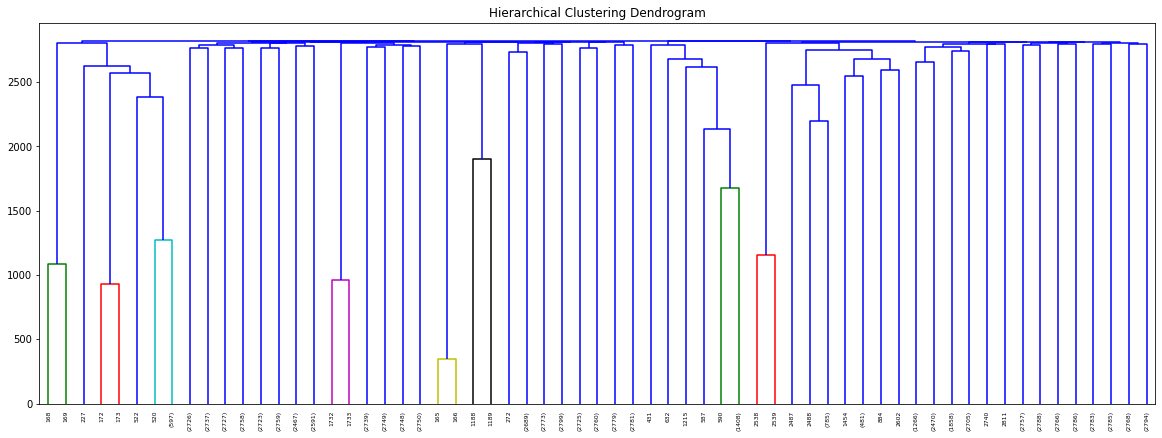

In [29]:
# answer goes here
plt.figure(figsize=(20,7))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(hier, truncate_mode='level',p=6)
plt.show()



Finally, plot the resulting clusters on a map using the "scatter_geo" function from plotly.express. The map defaults to the entire world; the "scope" parameter is useful for narrowing down the region plotted in the map. The documentation can be found here:

https://www.plotly.express/plotly_express/#plotly_express.scatter_geo

Tip: If the markers on the map are too large, their size can be changed with the following line of code:

*fig.update_traces(marker=dict(size=...)))*

Do the clusters correspond to geographic areas you would expect? Experiment with other values for n_cluster and linkage and see how they affect the results.

In [33]:
# answer goes here
px.scatter_geo(data_frame=df, lat='Latitude',lon='Longitude', scope='usa',color='hier_cluster')



The cluster distribution was as expected. The pink, yellow, and orange are the outliers and they behave so with fewer in number and further from the center.